# Running LLaVa-NeXT-Video: a large multi-modal model on Google Colab

LLaVa-NeXT-Video is a new Large Vision-Language Model that enables interaction with videos and images. The model is based on a previuos series of models: [LLaVa-NeXT](https://huggingface.co/docs/transformers/main/en/model_doc/llava_next) that was trained exclusively on image-text data. The architecutre is same as in LLaVa-NeXT and is a decoder-based text model that takes concatenated vision hidden states with text hidden states.


<img src="http://drive.google.com/uc?export=view&id=1fVg-r5MU3NoHlTpD7_lYPEBWH9R8na_4">


LLaVA-NeXT surprisingly has strong performance in understanding video content with the AnyRes technique that it uses. The AnyRes technique naturally represents a high-resolution image into multiple images. This technique is naturally generalizable to represent videos because videos can be considered as a set of frames (similar to a set of images in LLaVa-NeXT). The current version of LLaVA-NeXT for videos has several improvements:

- LLaVA-Next-Video, with supervised fine-tuning (SFT) on top of LLaVA-Next on video data, achieves better video understanding capabilities and is a current SOTA among open-source models on [VideoMME bench](https://arxiv.org/pdf/2405.21075)
- LLaVA-Next-Video-DPO, which aligns the model response with AI feedback using direct preference optimization (DPO), shows further performance boost.

Transformers docs: https://huggingface.co/docs/transformers/main/en/model_doc/llava_next_video
project page: https://github.com/LLaVA-VL/LLaVA-NeXT



First we need to install the latest `transformers` from `main`, as the model has just been added. Also we'll install `bitsandbytes` to load the model in lower bits for [memory efficiency](https://huggingface.co/blog/4bit-transformers-bitsandbytes)

In [4]:
%pip install --upgrade -q accelerate bitsandbytes
%pip install git+https://github.com/huggingface/transformers.git

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-kua6vce4
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-kua6vce4
  Resolved https://github.com/huggingface/transformers.git to commit 006d9249ec0270ff6c4d3840979d23fe94bdc763
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
# we need av to be able to read the video
%pip install -q av

Note: you may need to restart the kernel to use updated packages.


## Load the model

Next, we load a model and corresponding processor from the hub.

We will specify a quantization config to load the model in 4 bits. Please refer to this [guide](https://huggingface.co/blog/4bit-transformers-bitsandbytes) for more details.

In [1]:
from transformers import BitsAndBytesConfig, LlavaNextVideoForConditionalGeneration, LlavaNextVideoProcessor
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

processor = LlavaNextVideoProcessor.from_pretrained("llava-hf/LLaVA-NeXT-Video-7B-hf")
model = LlavaNextVideoForConditionalGeneration.from_pretrained(
    "llava-hf/LLaVA-NeXT-Video-7B-hf",
    quantization_config=quantization_config,
    device_map='auto'
)

/home/saberwu2002/anaconda3/envs/llava-demo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:34<00:00, 11.48s/it]


## Preparing the video and image inputs

In order to read the video we'll use `av` and sample 8 frames. You can try to sample more frames if the video is long. The model was trained with 32 frames, but can ingest more as long as we're in the LLM backbone's max sequence length range.

In [2]:
import av
import numpy as np

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.

    Args:
        container (av.container.input.InputContainer): PyAV container.
        indices (List[int]): List of frame indices to decode.

    Returns:
        np.ndarray: np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

In [3]:
from huggingface_hub import hf_hub_download

# Download video from the hub
video_path_1 = hf_hub_download(repo_id="raushan-testing-hf/videos-test", filename="sample_demo_1.mp4", repo_type="dataset")
video_path_2 = hf_hub_download(repo_id="raushan-testing-hf/videos-test", filename="karate.mp4", repo_type="dataset")

container = av.open(video_path_1)

# sample uniformly 8 frames from the video (we can sample more for longer videos)
total_frames = container.streams.video[0].frames
indices = np.arange(0, total_frames, total_frames / 8).astype(int)
clip_baby = read_video_pyav(container, indices)


container = av.open(video_path_2)

# sample uniformly 8 frames from the video (we can sample more for longer videos)
total_frames = container.streams.video[0].frames
indices = np.arange(0, total_frames, total_frames / 8).astype(int)
clip_karate = read_video_pyav(container, indices)

In [14]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = clip_baby

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=100)
HTML(anim.to_html5_video())

In [4]:
# Lets also load 2 images for generation from image data

from PIL import Image
import requests

image_stop = Image.open(requests.get("https://www.ilankelman.org/stopsigns/australia.jpg", stream=True).raw)
image_snowman = Image.open(requests.get("https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.jpg", stream=True).raw)

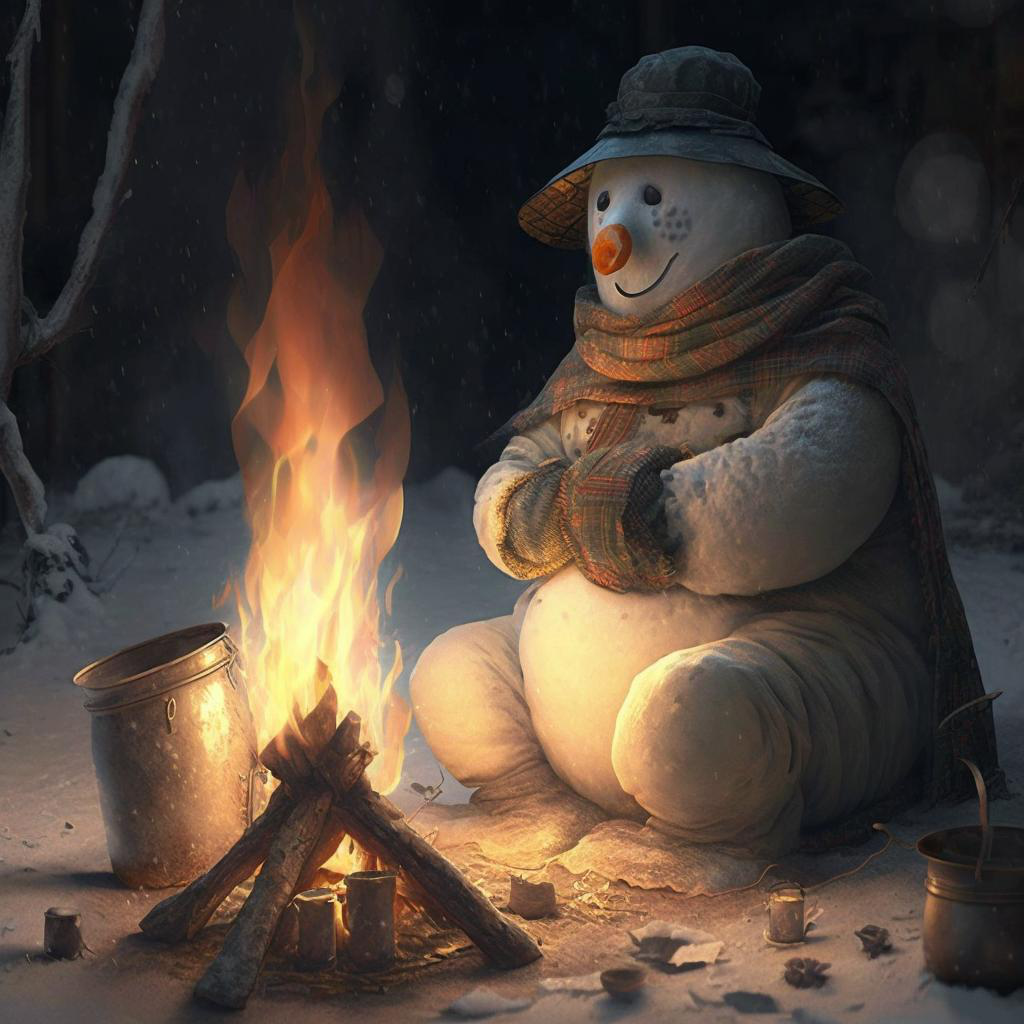

In [5]:
image_snowman

## Prepare a prompt and generate

In the prompt, you can refer to video using the special `<video>` or `<image>` token. To indicate which text comes from a human vs. the model, one uses USER and ASSISTANT respectively (note: it's true only for this checkpoint). The format looks as follows:

`USER: <video>\n<prompt> ASSISTANT:`


In other words, you always need to end your prompt with ASSISTANT:.


Manually adding USER and ASSISTANT to your prompt can be error-prone since each checkpoint has its own prompt format expected, depending on the backbone language model. Luckily we can use `apply_chat_template` to make it easier.

Chat templates are special templates written in jinja and added to the model's config. Whenever we call `apply_chat_template`, the jinja template in filled in with your text instruction.

To use chat template simply build a list of messages, with role and content keys, and then pass it to the `apply_chat_template()` method. Once you do that, you’ll get output that’s ready to go! When using chat templates as input for model generation, it’s also a good idea to use `add_generation_prompt=True` to add a generation prompt. See [the docs](https://huggingface.co/docs/transformers/main/en/chat_templating) for more details

In [6]:
# Each "content" is a list of dicts and you can add image/video/text modalities
conversation = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "Why is this video funny?"},
              {"type": "video"},
              ],
      },
]

conversation_2 = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "What do you see in this video?"},
              {"type": "video"},
              ],
      },
]

prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
prompt_2 = processor.apply_chat_template(conversation_2, add_generation_prompt=True)


In [7]:
# As you can see we got the USER: ASSISTANT: format prompt
prompt

'USER: <video>\nWhy is this video funny? ASSISTANT:'

In [8]:
# we still need to call the processor to tokenize the prompt and get pixel_values for videos
inputs = processor([prompt, prompt_2], videos=[clip_baby, clip_karate], padding=True, return_tensors="pt").to(model.device)

In [9]:
generate_kwargs = {"max_new_tokens": 100, "do_sample": True, "top_p": 0.9}

output = model.generate(**inputs, **generate_kwargs)
generated_text = processor.batch_decode(output, skip_special_tokens=True)

In [10]:
print(generated_text)

["USER: \nWhy is this video funny? ASSISTANT: The humor in this video is a result of the contrast between the expectations and reality. The child is seen engrossed in reading a book, yet upon closer inspection, it's apparent that she's not reading anything, and she's playing with her food. It's a playful and relatable moment because many children when they are young like to pretend to eat or play with food as if they're actually reading. The humor comes from the unexpectedness of", "USER: \nWhat do you see in this video? ASSISTANT: The video features a person in martial arts attire, likely a karate uniform, standing in a room with bright sunlight coming in from the windows, creating a warm and spacious atmosphere. The light illuminates the individual's form as they focus on something outside the frame. The room appears to be an indoor training facility, possibly a dojo, with bare walls and a high ceiling, suggesting it might be a space designed for martial arts or physical training."]


### Generate from images and image+video data

To generate from images we have to change the special token to `<image>` or indicate an "image" modality in the chat template, that's it! Let's see how it works

In [11]:
# Each "content" is a list of dicts and you can add image/video/text modalities
conversation_image = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "What do you see in this image?"},
              {"type": "image"},
              ],
      },
]

conversation_2_image = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "What color is the sign?"},
              {"type": "image"},
              ],
      },
]

prompt_image = processor.apply_chat_template(conversation_image, add_generation_prompt=True)
prompt_2_image = processor.apply_chat_template(conversation_2_image, add_generation_prompt=True)

In [12]:
prompt

'USER: <video>\nWhy is this video funny? ASSISTANT:'

In [13]:
inputs = processor([prompt_image, prompt_2_image], images=[image_snowman, image_stop], padding=True, return_tensors="pt").to(model.device)

In [14]:
generate_kwargs = {"max_new_tokens": 50, "do_sample": True, "top_p": 0.9}

output = model.generate(**inputs, **generate_kwargs)
generated_text = processor.batch_decode(output, skip_special_tokens=True)

In [15]:
print(generated_text)

['USER: \nWhat do you see in this image? ASSISTANT: In the image, there is a snowman sitting on the ground beside a small, makeshift campfire. The snowman appears to be constructed of snow and has a hat with a scarf wrapped around it. In front of the snowman', 'USER: \nWhat color is the sign? ASSISTANT: The sign in the image is red.']


We can feed images and videos in one go instead of running separate generations for image and video. Also we can interleave images with videos inside one prompt, although the training dataset didn't see that kind of examples.

For the processing just make sure to pass images/videos in the same order as they appear in the prompts, starting from the first prompt until the last prompt. You can pass all visual data as flattenned list as shown below, only order matters





In [16]:
inputs = processor([prompt, prompt_image, prompt_2_image], images=[image_snowman, image_stop], videos=[clip_baby], padding=True, return_tensors="pt").to(model.device)

In [17]:
generate_kwargs = {"max_new_tokens": 40, "do_sample": True, "top_p": 0.9}

output = model.generate(**inputs, **generate_kwargs)
generated_text = processor.batch_decode(output, skip_special_tokens=True)
print(generated_text)

['USER: \nWhy is this video funny? ASSISTANT: The video is funny because it captures a child reading a book, oblivious to the fact that their shirt is on backward, revealing their back. The child seems engross', 'USER: \nWhat do you see in this image? ASSISTANT: The image shows a stylized, animated snowman sitting on the ground next to a small, intimate campfire. The snowman appears to be wearing a warm hat and a coat with', 'USER: \nWhat color is the sign? ASSISTANT: The sign is red and has a white border.']


In [18]:
# For multi-turn convwersations just continue stacking up messages in the chat template
conversation_multiturn = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "What do you see in this video?"},
              {"type": "video"},
              ],
      },
      {
          "role": "assistant",
          "content": [
              {"type": "text", "text": "I see a baby reading a book."},
              ],
      },
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "Why is it funny?"},
              ],
      },
]

prompt_multiturn = processor.apply_chat_template(conversation_multiturn, add_generation_prompt=True)
print(prompt_multiturn)

USER: <video>
What do you see in this video? ASSISTANT: I see a baby reading a book. USER: Why is it funny? ASSISTANT:
